In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3
from scipy import stats
plt.style.use('ggplot')
con = sqlite3.connect("lahmansbaseballdb.sqlite")

In [2]:
def plot_corr(df, col1, col2, title, rx, ry):
    x = df[col1]
    y = df[col2]
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    
    rsqr = np.corrcoef(df[col1], df[col2])[0][1]

    fig, ax = plt.subplots()
    df[[col1,col2]].plot(kind='scatter', x=col1, y=col2, 
                                                           title=title, ax=ax)
    ax.plot(x, intercept+(slope*x))
    ax.text(rx, ry, '$r = %0.4f$'%rsqr, fontsize=20)

In [3]:
yoy_comparison = pd.read_sql('''

WITH grouped_pitchers AS (
    SELECT playerID, 
           yearID, 
           sum(ER) as ER, 
           sum(HR) as HR, 
           sum(BB) as BB, 
           sum(HBP) as HBP, 
           sum(SO) as SO, 
           sum(IPouts) as IPouts 
    FROM pitching sp
    WHERE yearID BETWEEN 1995 AND 2016
    GROUP BY playerID, yearID 
    HAVING sum(IPouts)>483
)

SELECT p1.playerID as playerID, 
       p1.yearID as yearID, 
       p1.IPouts, 
       p1.ER, 
       p1.HR,
       p1.BB, 
       p1.HBP, 
       p1.SO, 
       p2.playerID as playerID_2, 
       cast(p2.yearID as unsigned) as yearID_2,
       p2.IPouts as IPouts_2, 
       p2.ER as ER_2, 
       p2.HR as HR_2, 
       p2.BB as BB_2, 
       p2.HBP as HBP_2, 
       p2.SO as SO_2 
FROM grouped_pitchers p1, grouped_pitchers p2
WHERE p1.yearID+1=p2.yearID AND p1.playerID=p2.playerID
''', con=con)

In [4]:
yoy_comparison = yoy_comparison.dropna().reset_index(drop=True)
yoy_comparison['yearID_2'] = yoy_comparison['yearID_2'].astype(int)

In [5]:
yoy_comparison.head()

,playerID,yearID,IPouts,ER,HR,BB,HBP,SO,playerID_2,yearID_2,IPouts_2,ER_2,HR_2,BB_2,HBP_2,SO_2
0,abbotpa01,2000,537,84,23,80,5,100,abbotpa01,2001,489,77,21,87,7,118
1,alvarwi01,1995,525,84,21,93,2,118,alvarwi01,1996,652,102,21,97,4,181
2,alvarwi01,1996,652,102,21,97,4,181,alvarwi01,1997,636,82,18,91,4,179
3,anderbr02,2003,593,83,27,43,4,87,anderbr02,2004,498,104,33,53,1,70
4,appieke01,1995,604,87,14,80,8,185,appieke01,1996,634,85,17,75,5,207


In [6]:
fip_constant = pd.read_csv('historical_constant.csv', 
                          usecols=["Season",'cFIP'])
fip_constant.columns = ['yearID', 'cFIP']

In [7]:
yoy_comparison['cfip'] = pd.merge(yoy_comparison[['yearID']], fip_constant, on='yearID',how='left')['cFIP']
yoy_comparison['cfip_2'] = pd.merge(yoy_comparison[['yearID_2']], fip_constant, left_on='yearID_2', right_on='yearID',how='left')['cFIP']

In [8]:
yoy_comparison['era_year_1'] = yoy_comparison.apply(lambda row: 9*(row['ER']/(row['IPouts']/3)), axis=1)
yoy_comparison['era_year_2'] = yoy_comparison.apply(lambda row: 9*(row['ER_2']/(row['IPouts_2']/3)), axis=1)

In [9]:
yoy_comparison.head()

,playerID,yearID,IPouts,ER,HR,BB,HBP,SO,playerID_2,yearID_2,IPouts_2,ER_2,HR_2,BB_2,HBP_2,SO_2,cfip,cfip_2,era_year_1,era_year_2
0,abbotpa01,2000,537,84,23,80,5,100,abbotpa01,2001,489,77,21,87,7,118,3.134,3.049,4.223464,4.251534
1,alvarwi01,1995,525,84,21,93,2,118,alvarwi01,1996,652,102,21,97,4,181,3.103,3.172,4.320000,4.223926
2,alvarwi01,1996,652,102,21,97,4,181,alvarwi01,1997,636,82,18,91,4,179,3.172,3.109,4.223926,3.481132
3,anderbr02,2003,593,83,27,43,4,87,anderbr02,2004,498,104,33,53,1,70,3.031,3.049,3.779089,5.638554
4,appieke01,1995,604,87,14,80,8,185,appieke01,1996,634,85,17,75,5,207,3.103,3.172,3.889073,3.619874


In [10]:
'((13*HR)+(3*(BB+HBP))-(2*K))/IP + constant'

'((13*HR)+(3*(BB+HBP))-(2*K))/IP + constant'

In [11]:
yoy_comparison['fip_year_1'] = yoy_comparison.apply(lambda row: ((13*row['HR'])+(3*(row['BB']+row['HBP']))-(2*row['SO']))/(row['IPouts']/3)+row['cfip'], axis=1)
yoy_comparison['fip_year_2'] = yoy_comparison.apply(lambda row: ((13*row['HR_2'])+(3*(row['BB_2']+row['HBP_2']))-(2*row['SO_2']))/(row['IPouts_2']/3)+row['cfip_2'], axis=1)

In [12]:
yoy_comparison.head()

,playerID,yearID,IPouts,ER,HR,BB,HBP,SO,playerID_2,yearID_2,...,HR_2,BB_2,HBP_2,SO_2,cfip,cfip_2,era_year_1,era_year_2,fip_year_1,fip_year_2
0,abbotpa01,2000,537,84,23,80,5,100,abbotpa01,2001,...,21,87,7,118,3.134,3.049,4.223464,4.251534,5.111654,5.006055
1,alvarwi01,1995,525,84,21,93,2,118,alvarwi01,1996,...,21,97,4,181,3.103,3.172,4.320000,4.223926,4.943000,4.156663
2,alvarwi01,1996,652,102,21,97,4,181,alvarwi01,1997,...,18,91,4,179,3.172,3.109,4.223926,3.481132,4.156663,3.868434
3,anderbr02,2003,593,83,27,43,4,87,anderbr02,2004,...,33,53,1,70,3.031,3.049,3.779089,5.638554,4.639769,5.765867
4,appieke01,1995,604,87,14,80,8,185,appieke01,1996,...,17,75,5,207,3.103,3.172,3.889073,3.619874,3.480483,3.394397


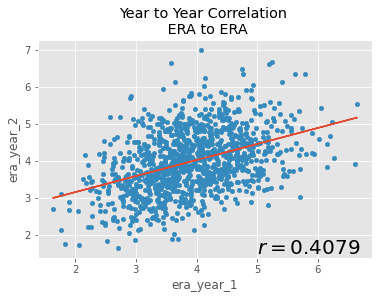

In [13]:
plot_corr(yoy_comparison, 
          'era_year_1', 
          'era_year_2', 
          'Year to Year Correlation \n ERA to ERA',
          5, 1.5)

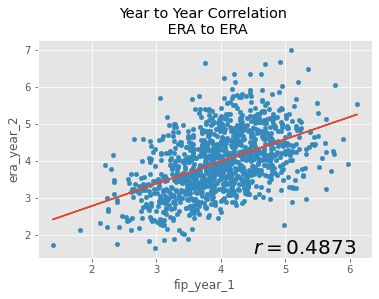

In [14]:
plot_corr(yoy_comparison, 
          'fip_year_1', 
          'era_year_2', 
          'Year to Year Correlation \n ERA to ERA',
          4.5, 1.5)

## xFIP and SIERA predict next year ERA better than FIP

## Team Wins Predicted by Runs - Pythagorean

In [15]:
team_perf = pd.read_sql('select yearID, teamID, R, RA, W, L from teams where yearID>1995;', con=con)
team_perf['W_PCT'] = team_perf.apply(lambda row: row['W']/float((row['W']+row['L'])), axis=1)

In [16]:
team_perf.query("yearID==2016").sort_values(['yearID','W_PCT'], ascending=[1,0]).tail(30).head(5)

,yearID,teamID,R,RA,W,L,W_PCT
613,2016,CHN,808,556,103,58,0.639752
609,2016,TEX,765,757,95,67,0.586420
625,2016,WAS,763,612,95,67,0.586420
599,2016,CLE,777,676,94,67,0.583851
597,2016,BOS,878,694,93,69,0.574074


## Calculate Pythag
W%=[(Runs Scored)^2]/[(Runs Scored)^2 + (Runs Allowed)^2]

In [17]:
team_perf['PYTHAG'] = team_perf.apply(lambda row: (row['R']**2)/float((row['R']**2)+(row['RA']**2)), axis=1)

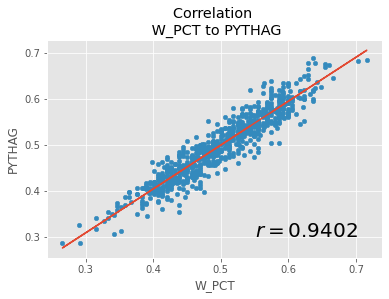

In [18]:
plot_corr(team_perf, 'W_PCT', 'PYTHAG', 'Correlation \n W_PCT to PYTHAG', .55, .3)

In [19]:
team_perf.query("yearID==2016").sort_values(['yearID','W_PCT'], ascending=[1,0]).tail(30).head()

,yearID,teamID,R,RA,W,L,W_PCT,PYTHAG
613,2016,CHN,808,556,103,58,0.639752,0.678653
609,2016,TEX,765,757,95,67,0.586420,0.505256
625,2016,WAS,763,612,95,67,0.586420,0.608510
599,2016,CLE,777,676,94,67,0.583851,0.569177
597,2016,BOS,878,694,93,69,0.574074,0.615466


## Calculate Pythagenpat
((rs + ra)/g)^.287

In [20]:
pythag_lookup = pd.read_sql('''
    SELECT yearID, 
           Round((sum(R)+sum(RA))/sum(G),4) as PYPAT 
    FROM teams 
    WHERE yearID>1995 group by yearID;
''', con=con)

In [21]:
pythag_lookup['PYPAT_EXP'] = pythag_lookup['PYPAT'].pow(.287)

In [22]:
pythag_lookup

,yearID,PYPAT,PYPAT_EXP
0,1996,10.0,1.936422
1,1997,9.0,1.878744
2,1998,9.0,1.878744
3,1999,10.0,1.936422
4,2000,10.0,1.936422
5,2001,9.0,1.878744
6,2002,9.0,1.878744
7,2003,9.0,1.878744
8,2004,9.0,1.878744
9,2005,9.0,1.878744


In [23]:
team_perf['PYPAT_EXP'] = pd.merge(team_perf, pythag_lookup, on='yearID', how='left')['PYPAT_EXP']

In [24]:
team_perf['PYTHAGENPAT'] = team_perf.apply(lambda row: (row['R']**row['PYPAT_EXP'])/float((row['R']**row['PYPAT_EXP'])+(row['RA']**row['PYPAT_EXP'])), axis=1)

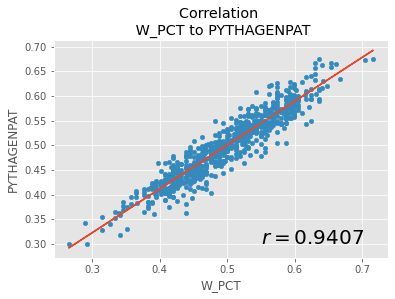

In [25]:
plot_corr(team_perf, 'W_PCT', 'PYTHAGENPAT', 'Correlation \n W_PCT to PYTHAGENPAT', .55, .3)